## Imports

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import cv2
import time
import pickle 
import shutil 
import numpy as np
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from sys import getsizeof
import matplotlib.pyplot as plt

import faiss
import face_recognition
from deepface import DeepFace
from multiprocessing import Pool, cpu_count


## Initializing Constants

In [21]:
MODEL_NAME = "ArcFace" 
DETECTOR_BACKEND = "mtcnn" 
NORMALIZATION = "ArcFace"

TARGET_SIZE = (112, 112) 
NUM_OF_DIMS = 512 

# DB_SOURCE = Path("./DB/")  
# QUERY_SOURCE = Path("./QueryImages/") 
INPUT_DATASET = Path("../data/CleanData/")

## Data Cleaning

In [24]:
# iterr = 0

# for person_img in os.listdir(DB_SOURCE):
#     person_name = os.path.splitext(person_img)[0]
#     dest_person_name = person_name.replace(" ", "_").replace(".", "").lower()
#     if len(os.listdir(QUERY_SOURCE / person_name)) == 5:
#         os.makedirs(str(INPUT_DATASET / dest_person_name), exist_ok=True)
#         for index, image in enumerate(os.listdir(QUERY_SOURCE / person_name)):
#             img_source = str(QUERY_SOURCE / person_name / image)     
#             img_destination = str(INPUT_DATASET / dest_person_name / f"{index}{os.path.splitext(image)[1]}")
#             shutil.copy(img_source, img_destination)
#             iterr += 1
#         img_source = str(DB_SOURCE / person_img)
#         img_destination = str(INPUT_DATASET / dest_person_name / f"{index+1}{os.path.splitext(image)[1]}")
#         shutil.copy(img_source, img_destination)
#         iterr += 1

# iterr # 768

768

## Utility Functions

In [22]:
def read_img(img_path):
    img = cv2.imread(img_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [23]:
def face_extraction_and_alignment(img_path):
    return DeepFace.extract_faces(
        img_path = img_path,
        target_size = TARGET_SIZE,
        detector_backend = DETECTOR_BACKEND,
        enforce_detection = True,
        align = True,
        grayscale = False,
    )[0]["face"]

In [24]:
def compare_original_and_extracted_face(img_path):
    target_img = face_extraction_and_alignment(img_path)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))
    original_img = read_img(img_path) 
    ax[0].imshow(original_img) 
    ax[0].axis("off")
    ax[1].imshow(target_img)
    ax[1].axis("off")
    plt.show()

In [25]:
def show_pic(img_path):
    img = read_img(img_path) 
    plt.imshow(img) 
    plt.axis("off")
    plt.show()

In [26]:
def face_enc_with_fr(img_path, known_face_locations):
    image_arr = face_recognition.load_image_file(img_path)
    img_enc = face_recognition.face_encodings(
        model='large', 
        face_image=image_arr, 
        known_face_locations=[known_face_locations], 
        num_jitters=1, 
    )[0]
    return img_enc 

def face_enc_and_extract_face_coordinates_with_df_lib(img_path):
    representation = DeepFace.represent(
        img_path=img_path,
        model_name=MODEL_NAME,
        normalization=NORMALIZATION,
        detector_backend=DETECTOR_BACKEND,
        align=True,
        enforce_detection=True,
    )[0]
    face_coordinates = representation["facial_area"]
    face_enc = representation["embedding"]
    face_enc = np.array(face_enc, dtype="f")
    # Extracting the coordinates and dimensions
    left = face_coordinates['x']
    top = face_coordinates['y']
    right = left + face_coordinates['w']
    bottom = top + face_coordinates['h']
    return [face_enc, (top, right, bottom, left)]

## Visualizing the dataset

1/1 [==============================] - 0s 106ms/step


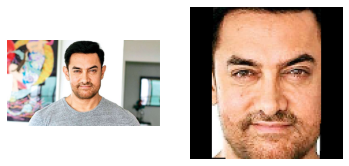

In [8]:
compare_original_and_extracted_face(str(INPUT_DATASET / "aamir_khan" / "5.jpg"))

1/1 [==============================] - 0s 23ms/step

Face Detection and Alignment took time 1.1056411266326904 seconds



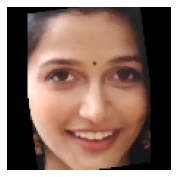

In [9]:
tic = time.time()
detected_and_aligned_face = face_extraction_and_alignment(str(INPUT_DATASET / "anaika_soti" / "5.jpg")) 
toc = time.time() 
print(f"\nFace Detection and Alignment took time {toc-tic} seconds\n") 
plt.figure(figsize=(3, 3))
plt.imshow(detected_and_aligned_face)
plt.axis("off")
plt.show()

## Vectorizing the DataBase & Query Images

In [10]:
[enc, coordi] = face_enc_and_extract_face_coordinates_with_df_lib(
    str(INPUT_DATASET / "anaika_soti" / "5.jpg")
    )

1/1 [==============================] - 0s 20ms/step


In [11]:
len(enc)

512

In [12]:
len(coordi)

4

In [13]:
DB_FACE_PATHS = []

for person_name in os.listdir(INPUT_DATASET):
    for img_name in os.listdir(INPUT_DATASET / person_name):
        img_path = str(INPUT_DATASET / person_name / img_name)
        DB_FACE_PATHS.append(img_path)

with open(f'../artifacts/DB_FACE_PATHS.pickle', 'wb') as handle:
    pickle.dump(DB_FACE_PATHS, handle, protocol = pickle.HIGHEST_PROTOCOL) 

In [84]:
DB_FACE_ENC = []
DB_FACE_COORDINATES = []

for img_path in DB_FACE_PATHS:
    [encoding, coordinates] = face_enc_and_extract_face_coordinates_with_df_lib(img_path)
    DB_FACE_ENC.append(encoding)
    DB_FACE_COORDINATES.append(coordinates)

In [16]:
with open("../artifacts/DB_FACE_ENC.pickle", "wb") as handle:
    pickle.dump(DB_FACE_ENC, handle, protocol = pickle.HIGHEST_PROTOCOL)

with open("../artifacts/DB_FACE_COORDINATES.pickle", "wb") as handle:
    pickle.dump(DB_FACE_COORDINATES, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [18]:
DB_FACE_PATHS[0]

'../data/CleanData/arun_vijay/5.jpg'

In [19]:
DB_FACE_ENC[0]

array([ 0.18435933,  0.49773747,  0.13786787, -0.2540668 , -0.12604477,
        0.03110872, -0.08152402, -0.09364262, -0.13283935,  0.0771507 ,
        0.01605895, -0.01110956,  0.22459602, -0.00637902, -0.28298488,
        0.08602037,  0.05095342, -0.16311826, -0.08634909, -0.08378378,
       -0.2683777 ,  0.29451802, -0.05708719,  0.06768057, -0.02299292,
       -0.12453203, -0.10901503,  0.05639792, -0.10257238, -0.33633178,
        0.17509067,  0.0245811 ,  0.36532754, -0.30795714, -0.10176633,
       -0.18266729, -0.43746686,  0.12988335, -0.30016068,  0.19105582,
       -0.00607039,  0.3015557 , -0.03563511,  0.04834756, -0.29789606,
        0.05553386, -0.10650585, -0.01521879, -0.15489563,  0.0216104 ,
        0.07724538, -0.26118493, -0.20315616, -0.11229146,  0.10913074,
       -0.3127757 ,  0.13980919,  0.1710798 ,  0.20981151,  0.10441897,
        0.46719602,  0.01728977, -0.03118143, -0.20628576, -0.07737481,
       -0.14890468, -0.0220078 ,  0.15858243,  0.14385056, -0.07

In [20]:
DB_FACE_COORDINATES[0]

(142, 493, 399, 293)

## Importing the Vectorized Images and DB dictionaries

In [35]:
with open('../artifacts/DB_FACE_PATHS.pickle', 'rb') as handle:
    DB_FACE_PATHS = pickle.load(handle)

# with open('../artifacts/DB_FACE_ENC.pickle', 'rb') as handle:
#     DB_FACE_ENC = pickle.load(handle)

with open('../artifacts/DB_FACE_COORDINATES.pickle', 'rb') as handle:
    DB_FACE_COORDINATES = pickle.load(handle)

In [24]:
getsizeof(DB_FACE_COORDINATES)

6200

## Creating FAISS Indexing Object

In [25]:
embeddings = np.array(DB_FACE_ENC, dtype='f')

In [26]:
import faiss
tic = time.time()

# index = faiss.IndexFlatL2(NUM_OF_DIMS) # euclidean
FAISS_INDEXING_OBJ = faiss.IndexFlatIP(NUM_OF_DIMS) # cosine
faiss.normalize_L2(embeddings)

toc = time.time()
print(f"faiss instance is initialized in {toc-tic} seconds")

faiss instance is initialized in 0.003153085708618164 seconds


In [27]:
# add 1M sized facial database into faiss
tic = time.time()

FAISS_INDEXING_OBJ.add(embeddings)

toc = time.time()
print(f"{len(embeddings)} vectors stored in faiss intance in {toc-tic} seconds")

768 vectors stored in faiss intance in 0.0011107921600341797 seconds


In [28]:
with open(f'../artifacts/FAISS_INDEXING_OBJ.pickle', 'wb') as handle:
    pickle.dump(FAISS_INDEXING_OBJ, handle, protocol = pickle.HIGHEST_PROTOCOL)

## Searching for similar pictures with the FAISS Object

In [36]:
with open('../artifacts/FAISS_INDEXING_OBJ.pickle', 'rb') as handle:
    FAISS_INDEXING_OBJ = pickle.load(handle)

with open('../artifacts/DB_FACE_PATHS.pickle', 'rb') as handle:
    DB_FACE_PATHS = pickle.load(handle)

In [28]:
# target_path = "../data/CleanData/kartik_aaryan/5.jpg" 
# target_path = "../data/CleanData/anupama_parameswaran/5.jpg" 
# target_path = "../data/CleanData/aamir_khan/5.jpg" 
target_path = "../data/CleanData/alizeh_shah/5.jpg"
target_embedding = DB_FACE_ENC[DB_FACE_PATHS.index(target_path)]
target_embedding = np.expand_dims(target_embedding, axis=0)

NameError: name 'DB_FACE_ENC' is not defined

In [33]:
k = 10 
tic = time.time()

distances, neighbours = FAISS_INDEXING_OBJ.search(target_embedding, k)

toc = time.time()
print(f"search completed in {toc - tic} seconds")

search completed in 0.0008437633514404297 seconds


In [34]:
neighbours

array([[229, 231, 275, 154, 230, 601, 150,  17, 474,   8]])

In [35]:
distances

array([[3.77675  , 2.131304 , 2.1059387, 1.9613909, 1.9456787, 1.9003044,
        1.7961913, 1.7634436, 1.753406 , 1.7183714]], dtype=float32)

1th closest image in 768 database


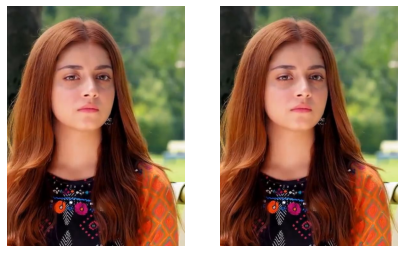

2th closest image in 768 database


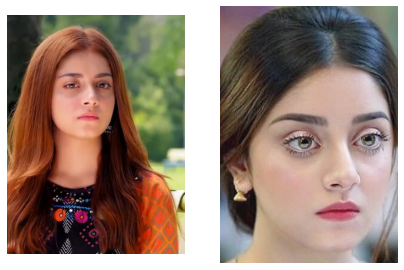

3th closest image in 768 database


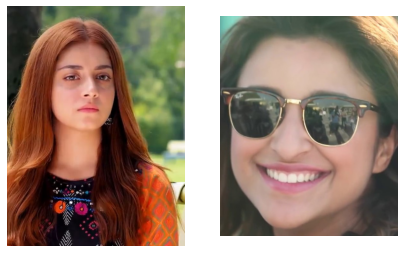

4th closest image in 768 database


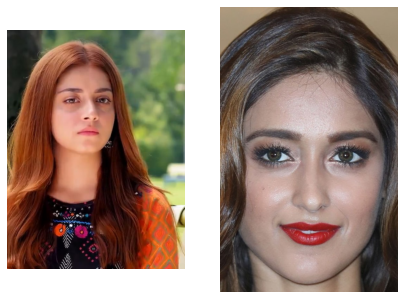

5th closest image in 768 database


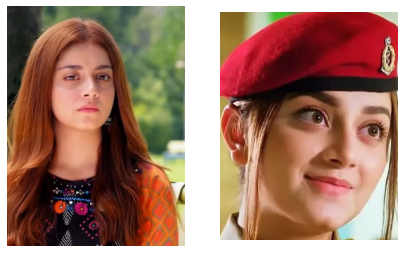

6th closest image in 768 database


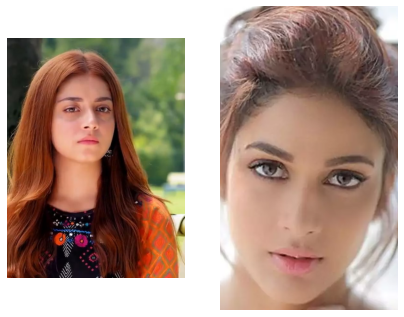

7th closest image in 768 database


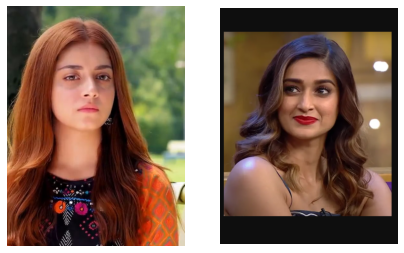

8th closest image in 768 database


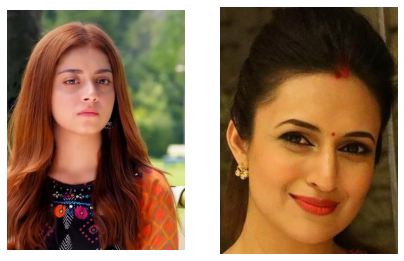

9th closest image in 768 database


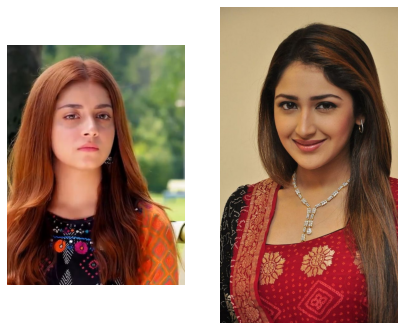

10th closest image in 768 database


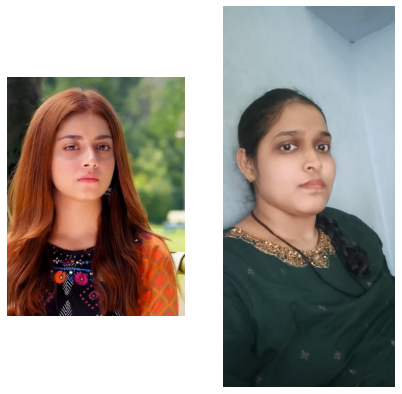

In [36]:
for idx, neighbour in enumerate(neighbours[0]):
    neighbour_img_path = DB_FACE_PATHS[neighbour]
    print(f"{idx+1}th closest image in {len(DB_FACE_PATHS)} database")
    fig = plt.figure(figsize=(7, 7))
    fig.add_subplot(1,2,1)
    plt.imshow(read_img(target_path))
    plt.axis("off")
    fig.add_subplot(1,2,2)
    plt.imshow(read_img(neighbour_img_path))
    plt.axis("off")
    plt.show()

## Exploring the face_recognition package

### Exploring compare_faces method

In [110]:
target_image_arr = face_recognition.load_image_file(target_path)

target_image_enc = face_recognition.face_encodings(
    face_image = target_image_arr,
    known_face_locations = None,
    num_jitters = 1,
    model = 'large',
)[0]

known_faces = []
for neighbour in neighbours[0]:
    neighbour_img_path = Query_face_path_reps_locations[neighbour][0]
    neighbour_img_arr = face_recognition.load_image_file(neighbour_img_path)
    neighbour_img_enc = face_recognition.face_encodings(
        face_image = neighbour_img_arr, 
        known_face_locations = None,
        num_jitters = 1,
        model = 'large',
    )[0]
    known_faces.append(neighbour_img_enc)

In [111]:
# results is an array of True/False telling if the unknown face matched anyone 
# in the known_faces array
results = face_recognition.compare_faces(
    known_faces, 
    target_image_enc,
    tolerance = 0.48
)
results

[True, False, False, True, False, False, False, False, False, False]

### Exploring face_distance method

In [112]:
distances = face_recognition.face_distance(
    face_encodings = known_faces, 
    face_to_compare = target_image_enc
)

In [113]:
distances 

array([0.        , 0.53957299, 0.6454748 , 0.46001816, 0.57873268,
       0.48891054, 0.73163636, 0.68846027, 0.7625775 , 0.65881117])

In [114]:
dic = dict(zip(neighbours[0], distances)) 

In [115]:
[(Query_face_path_reps_locations[item[0]][0], item[1]) for item in list(sorted(dic.items(), key=lambda item: item[1]))]

[('QueryImages/Aamir Khan/2.jpg', 0.0),
 ('QueryImages/Aamir Khan/4.png', 0.4600181572727369),
 ('QueryImages/Aamir Khan/1.jpg', 0.48891053873439455),
 ('QueryImages/Aamir Khan/5.png', 0.5395729860536199),
 ('QueryImages/Arya Cethirakath/3.png', 0.5787326779197571),
 ('QueryImages/Arya Cethirakath/1.jpg', 0.6454748027523287),
 ('QueryImages/bhanu/1.jpeg', 0.6588111662309186),
 ('QueryImages/Ali Fazal/1.jpg', 0.6884602680317772),
 ('QueryImages/Karthi/3.jpeg', 0.7316363606203832),
 ('QueryImages/Deepika Padukone/4.png', 0.762577503144426)]

### Exploring the Tolerance Value for compare_faces method

In [ ]:
tolerance = []
for person_1_img in tqdm(os.listdir(DB_SOURCE)):
    person_1_name = ".".join(person_1_img.split(".")[:-1])
    person_1_path = str(DB_SOURCE / person_1_img)
    # print(person_1_path)
    person_1_image_arr = face_recognition.load_image_file(person_1_path)
    person_1_image_enc = face_encodings(person_1_image_arr)
    known_faces = []
    for person_2_img in os.listdir(QUERY_SOURCE / person_1_name):
        person_2_path = str(QUERY_SOURCE / person_1_name / person_2_img)
        person_2_image_arr = face_recognition.load_image_file(person_2_path)
        person_2_image_enc = face_encodings(person_2_image_arr)
        known_faces.append(person_2_image_enc)
        # print(person_2_path)
    tances = face_recognition.face_tance(
        face_encodings = known_faces, 
        face_to_compare = person_1_image_enc
    )
    # print(tances)
    tolerance.append(np.median(tances))
    # print()
tolerance

100%|█████████████████████████████████████████| 129/129 [04:37<00:00,  2.15s/it]


[0.3556061539451734,
 0.43882977533940576,
 0.4577856250826683,
 0.5162375678348011,
 0.34650711539556717,
 0.4016819332194532,
 0.36440630517314204,
 0.414546116829475,
 0.3563400127245326,
 0.4313323466194446,
 0.4376168822727267,
 0.415872367702583,
 0.40315841191879903,
 0.4567871264339888,
 0.36115274379148854,
 0.3730248068897229,
 0.5009756837900061,
 0.41387466999567946,
 0.5128755700088553,
 0.37832125147783,
 0.35496560852691994,
 0.5318060770075619,
 0.4199226493791836,
 0.44550024853633435,
 0.48503693026441014,
 0.3681530358288588,
 0.38041923958169327,
 0.4666537078284982,
 0.3041904868415308,
 0.42722988240608994,
 0.4351080772015238,
 0.41188947251509145,
 0.44531385656791883,
 0.47621239259426795,
 0.4938366415668758,
 0.3250906799291193,
 0.5178485000972549,
 0.38450008436590194,
 0.394339252603509,
 0.43739734355658366,
 0.44167195656415703,
 0.33037795659202673,
 0.45919888132206693,
 0.4396442646115106,
 0.3677196764595082,
 0.4141178339337973,
 0.4743725483505464,

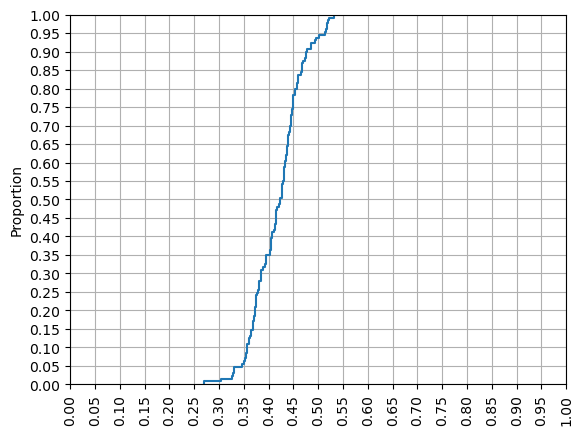

In [ ]:
sns.ecdfplot(tolerance)
plt.xticks([i/20 for i in range(21)], rotation=90)
plt.yticks([i/20 for i in range(21)])
plt.grid()
plt.show()

In [ ]:
tolerance = []
for person_1_img in tqdm(os.listdir(DB_SOURCE)):
    person_1_name = ".".join(person_1_img.split(".")[:-1])
    person_1_path = str(DB_SOURCE / person_1_img)
    # print(person_1_path)
    person_1_image_arr = face_recognition.load_image_file(person_1_path)
    person_1_image_enc = face_encodings(person_1_image_arr)
    known_faces = []
    for person_2_img in os.listdir(QUERY_SOURCE / person_1_name):
        person_2_path = str(QUERY_SOURCE / person_1_name / person_2_img)
        person_2_image_arr = face_recognition.load_image_file(person_2_path)
        person_2_image_enc = face_encodings(person_2_image_arr)
        known_faces.append(person_2_image_enc)
        # print(person_2_path)
    tances = face_recognition.face_tance(
        face_encodings = known_faces, 
        face_to_compare = person_1_image_enc
    )
    # print(tances)
    # tolerance.append(np.median(tances))
    tolerance.extend(tances)
    # print()
tolerance

100%|█████████████████████████████████████████| 129/129 [04:39<00:00,  2.16s/it]


[0.32529662366799594,
 0.3518861090715766,
 0.4622422844508665,
 0.37848727034679025,
 0.3556061539451734,
 0.49994207652931233,
 0.3436450327460892,
 0.44610729052922704,
 0.4029228235224444,
 0.43882977533940576,
 0.4968868439074121,
 0.4577856250826683,
 0.4175133885751445,
 0.4085868478308186,
 0.4832664590987744,
 0.5162375678348011,
 0.3624124894223383,
 0.5461895275499051,
 0.4410778244385062,
 0.5271501586385389,
 0.10951328918756621,
 0.4333255884769855,
 0.33719212589482755,
 0.34650711539556717,
 0.4305493821522119,
 0.40722238413756184,
 0.228131662204417,
 0.4016819332194532,
 0.38785765258669247,
 0.49896665708588483,
 0.43397525551181904,
 0.36440630517314204,
 0.31814235634109295,
 0.44864658944511443,
 0.3628007587339854,
 0.3849823077217564,
 0.451424522476863,
 0.36450749523915243,
 0.4958027396611777,
 0.414546116829475,
 0.4281635857370875,
 0.2917510750894158,
 0.305461010553306,
 0.3563400127245326,
 0.4165875524121304,
 0.40224171030042954,
 0.5537863033898185,


In [ ]:
np.percentile(tolerance, 99)

0.6094068052287842

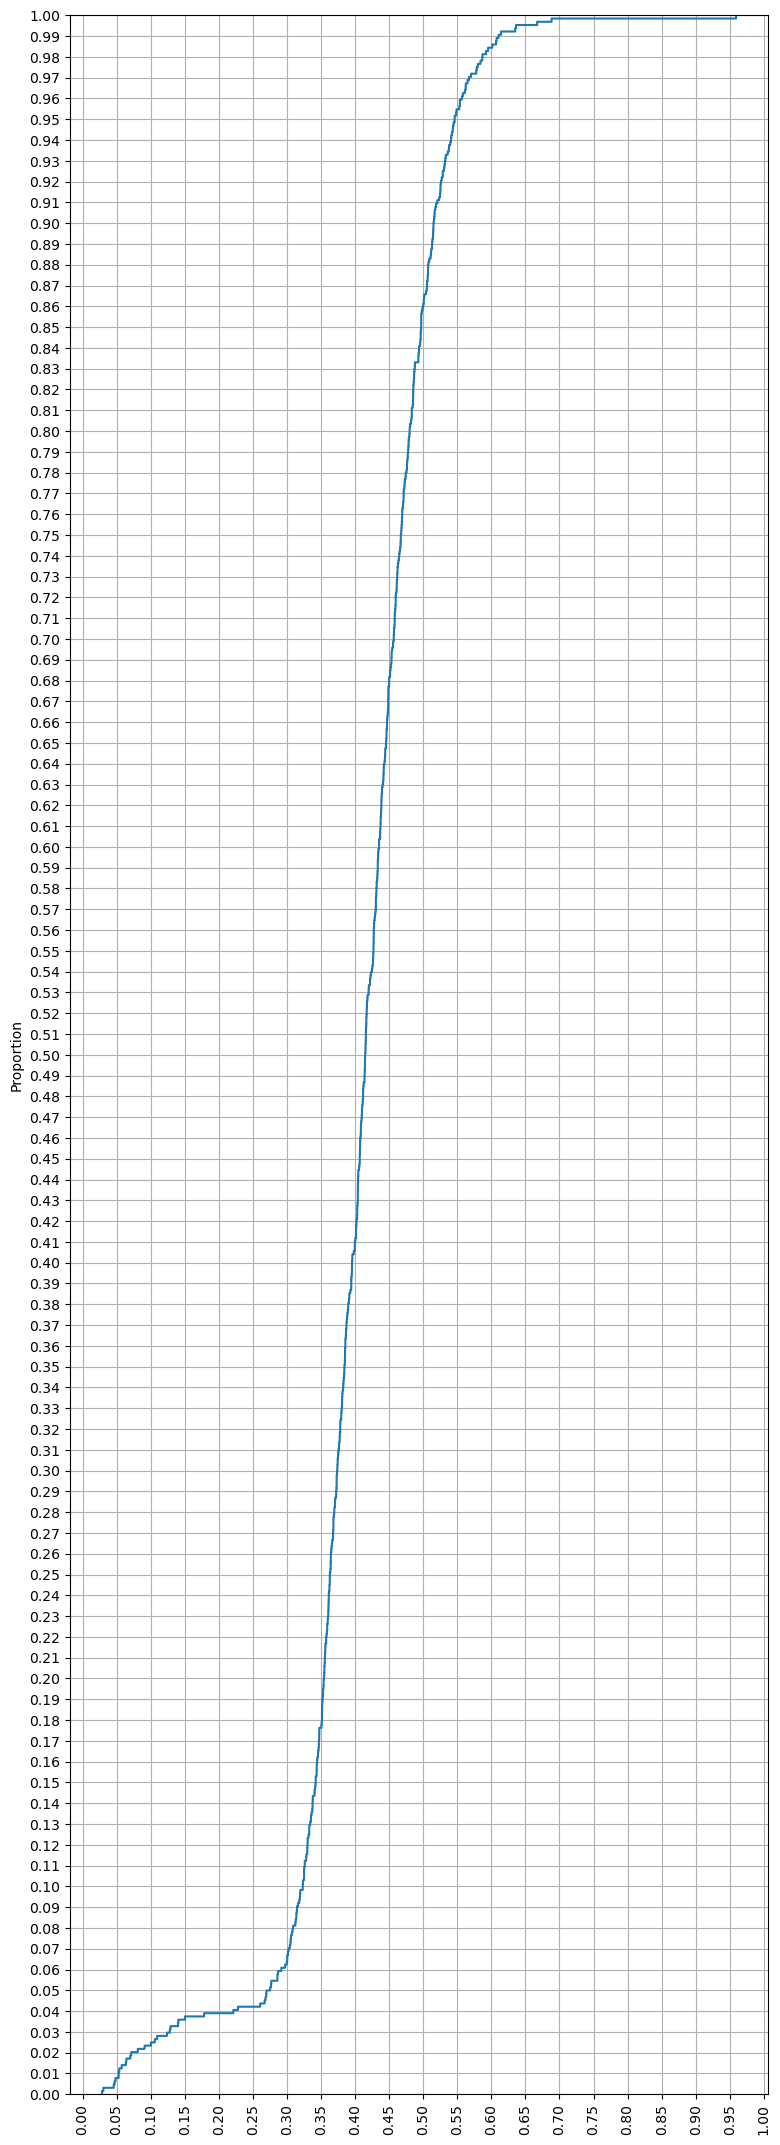

In [ ]:
plt.figure(figsize=(9, 27))
sns.ecdfplot(tolerance)
plt.xticks([i/20 for i in range(21)], rotation=90)
plt.yticks([i/100 for i in range(101)])
plt.grid()
plt.show()

### Extracting Face Bounding Box with Deep learning

In [59]:
face_recognition.face_locations(
    img = face_recognition.load_image_file("QueryImages/Divyendu Sharma/5.png"),
    number_of_times_to_upsample = 1,
    model = "cnn"
)

[(180, 335, 603, 0)]

In [60]:
positive_img_arr = face_recognition.load_image_file(
    "QueryImages/Divyendu Sharma/5.png"
)

positive_image_enc = face_recognition.face_encodings(
    face_image = positive_img_arr,
    known_face_locations = face_recognition.face_locations(
        img = positive_img_arr,
        number_of_times_to_upsample = 1,
        model = "cnn"
    ),
    num_jitters = 1,
    model = 'large',
)[0]

positive_image_enc

array([-0.11800198,  0.09467008,  0.08731739, -0.08859541, -0.03324034,
       -0.0327717 , -0.11298256, -0.1143096 ,  0.10522072, -0.18608832,
        0.29453772, -0.05663745, -0.23187064, -0.06183244,  0.00401195,
        0.0533325 , -0.12491174, -0.08371996, -0.07305332, -0.14576431,
        0.03851146,  0.14842357, -0.01146456,  0.07049698, -0.13293102,
       -0.37068564, -0.10376748, -0.09127804,  0.06147016, -0.09748858,
       -0.00691863,  0.00983575, -0.13787499, -0.03382872,  0.02826873,
        0.11273205,  0.00350514, -0.07404049,  0.2031565 ,  0.0457464 ,
       -0.0965406 , -0.03732779,  0.06497445,  0.25695261,  0.14201789,
        0.02316722,  0.06257673, -0.03688949,  0.1620328 , -0.18482399,
        0.05018687,  0.12242846,  0.14377327,  0.0547768 ,  0.16889788,
       -0.17922083, -0.00807369,  0.1518631 , -0.16884108,  0.14058867,
        0.01736558, -0.04916614,  0.00391425,  0.0252006 ,  0.17710841,
        0.08060867, -0.08623738, -0.20788889,  0.18082452, -0.19

## Inferance

In [37]:
def path_dis_processing(neighbour_idxs, distances):
    neighbour_idx_dis_pairs = list(zip(neighbour_idxs, distances))
    neighbour_idx_dis_pairs_sorted_in_asc_ord = list(sorted(
        neighbour_idx_dis_pairs, 
        key=lambda idx_dis: idx_dis[1],
        reverse=False  
    )) 
    neighbour_img_path_dis_pairs_sorted_in_asc_ord = [
        [DB_FACE_PATHS[idx], dis] for [idx, dis] in neighbour_idx_dis_pairs_sorted_in_asc_ord
    ]
    return neighbour_img_path_dis_pairs_sorted_in_asc_ord[1:] 

In [38]:
def top_4_matching_faces(neighbour_img_path_dis_pairs_sorted_in_asc_ord):
    entry_flag_dic = dict()
    result = []
    for neigh_img_path, dis in neighbour_img_path_dis_pairs_sorted_in_asc_ord:
        if os.path.dirname(neigh_img_path).split("/")[-1] not in entry_flag_dic:
            entry_flag_dic[os.path.dirname(neigh_img_path).split("/")[-1]] = True
            result.append([neigh_img_path, dis])
    return result[:4] 

In [42]:
def gathering_the_surrounding_known_faces(neighbour_idxs):
    known_faces = []
    for neigh_idx in neighbour_idxs:
        neigh_img_path = DB_FACE_PATHS[neigh_idx]
        known_face_locations = DB_FACE_COORDINATES[neigh_idx]
        neigh_img_enc = face_enc_with_fr(
            "../"+neigh_img_path, 
            known_face_locations=known_face_locations
        )
        known_faces.append(neigh_img_enc)
    return known_faces

In [43]:
def predict(target_path, k=10):
    # embedding the face
    [tar_enc, tar_coordinates] = face_enc_and_extract_face_coordinates_with_df_lib(target_path) 
    tar_enc = np.expand_dims(tar_enc, axis=0)
    # extracting the closest k embedding indexes
    distances, neighbour_idxs = FAISS_INDEXING_OBJ.search(tar_enc, k)
    neighbour_idxs, distances = neighbour_idxs[0], distances[0]
    # gather the surrounding known faces
    known_faces = gathering_the_surrounding_known_faces(neighbour_idxs)
    # calculating the distance between the target face and the closest k faces
    tar_enc = face_enc_with_fr(
        target_path, 
        known_face_locations=tar_coordinates
    )
    distances = face_recognition.face_distance(
        face_encodings=known_faces, 
        face_to_compare=tar_enc
    )
    # processing the image path and distance from target in ascending order
    neighbour_img_path_dis_pairs_sorted_in_asc_ord = path_dis_processing(
        neighbour_idxs, 
        distances
    )
    return top_4_matching_faces(neighbour_img_path_dis_pairs_sorted_in_asc_ord) 

In [44]:
tic = time.time()

# result = predict("../data/CleanData/anupama_parameswaran/1.jpg") 
# result = predict("../data/CleanData/aamir_khan/5.jpg")
# result = predict("../data/CleanData/kartik_aaryan/5.jpg") 
# result = predict("../data/CleanData/anupama_parameswaran/5.jpg") 
result = predict("../data/CleanData/alizeh_shah/5.jpg") 
# result = predict("../data/CleanData/aamir_khan/5.jpg") 
# result = predict("../data/CleanData/priyanka_arul_mohan/5.jpg") 
# result = predict("../data/CleanData/saikrishna/5.jpeg") 
# result = predict("../data/CleanData/sadak/5.jpg") 
# result = predict("../data/CleanData/catherine_tresa/4.jpg") 

# result = predict("Unknown/0ca8af14c1.jpg") 

for item in result:
    print(item)
print()

toc = time.time()
print(f"search completed in {toc - tic} seconds")

1/1 [==============================] - 0s 18ms/step
['data/CleanData/alizeh_shah/4.jpg', 0.4741337131828169]
['data/CleanData/lavanya_tripathi/0.png', 0.5134807529727985]
['data/CleanData/sayyeshaa_saigal/5.jpg', 0.5625392763675945]
["data/CleanData/ileana_d'cruz/5.jpg", 0.5714622545368838]

search completed in 1.9611034393310547 seconds


## Accuracy

In [50]:
def matching(neigh_img_path, target_path):
    # print(neigh_img_path, person_name)
    # print(os.path.dirname(neigh_img_path).split("/")[-1], person_name)
    target_name = os.path.dirname(target_path).split("/")[-1]
    neigh_name = os.path.dirname(neigh_img_path).split("/")[-1]
    # print("start", target_name, neigh_name, "end")
    # print(target_name, neigh_name)
    return target_name == neigh_name 

In [85]:
TP = 0
FN = 0
position = []
FN_responses = []

for target_path in tqdm(DB_FACE_PATHS):
    result = predict("../"+target_path)
    for idx, [neigh_img_path, dis] in enumerate(result):
        if matching(neigh_img_path, target_path): 
            TP += 1
            match_flag = True
            position.append([idx, [target_path, result]]) 
            break
        if idx == len(result)-1:
            FN += 1
            FN_responses.append([target_path, result])
            # print(target_path)
            # print(result)
            # print() 

In [53]:
with open(f'../artifacts/position.pickle', 'wb') as handle:
    pickle.dump(position, handle, protocol = pickle.HIGHEST_PROTOCOL) 

with open(f'../artifacts/FN_responses.pickle', 'wb') as handle:
    pickle.dump(FN_responses, handle, protocol = pickle.HIGHEST_PROTOCOL) 

In [54]:
with open(f'../artifacts/position.pickle', 'rb') as handle:
    position = pickle.load(handle)

with open(f'../artifacts/FN_responses.pickle', 'rb') as handle:
    FN_responses = pickle.load(handle)

In [55]:
TP + FN

768

In [56]:
TP, FN 

(757, 11)

In [57]:
TP / (TP + FN) # TN, FP == 0 

0.9856770833333334

In [58]:
arr = np.array([item[0] for item in position])

In [59]:
for i in range(10): 
    print(np.sum(arr == i) / (TP + FN))

0.9557291666666666
0.020833333333333332
0.006510416666666667
0.0026041666666666665
0.0
0.0
0.0
0.0
0.0
0.0


In [60]:
(1 - 0.985677)*100

1.4322999999999975

## Analyzing Incorrectly Predicted Data Points

In [74]:
FN_responses[0]

['data/CleanData/anaika_soti/2.png',
 [['data/CleanData/charmy_kaur/1.jpg', 0.5023568856408094],
  ['data/CleanData/bhoomika_chawla/0.jpg', 0.5716371679548409],
  ['data/CleanData/alizeh_shah/0.png', 0.5890573988329176],
  ['data/CleanData/catherine_tresa/1.jpg', 0.6076476496117454]]]

../data/CleanData/anaika_soti/2.png

INPUT PICTURE
1/1 [==============================] - 0s 19ms/step
PREDICTED AS
1/1 [==============================] - 0s 17ms/step


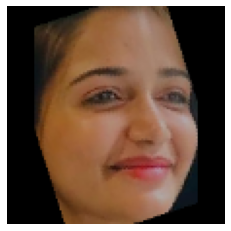

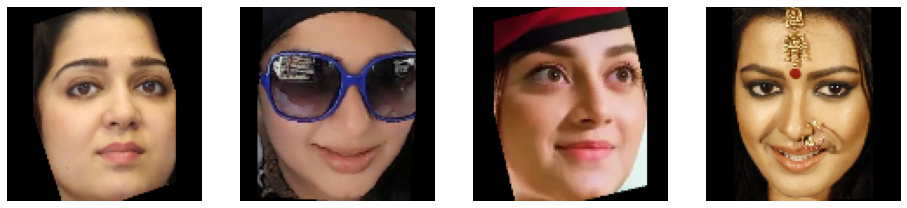

1/1 [==============================] - 0s 20ms/step
['data/CleanData/charmy_kaur/1.jpg', 0.5023568856408094]
['data/CleanData/bhoomika_chawla/0.jpg', 0.5716371679548409]
['data/CleanData/alizeh_shah/0.png', 0.5890573988329176]
['data/CleanData/catherine_tresa/1.jpg', 0.6076476496117454]

../data/CleanData/prabhas/4.jpg

INPUT PICTURE
1/1 [==============================] - 0s 18ms/step
PREDICTED AS
1/1 [==============================] - 0s 20ms/step


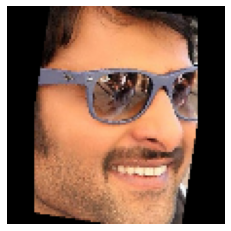

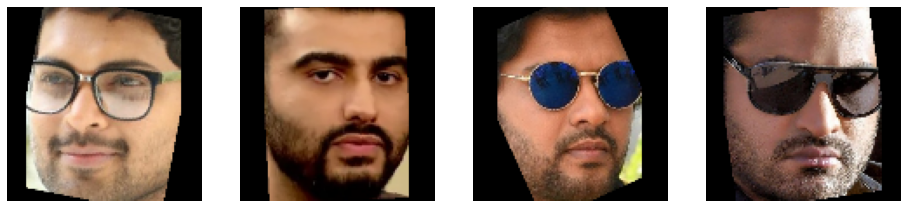

1/1 [==============================] - 0s 20ms/step
['data/CleanData/ajmal_ameer/0.jpg', 0.5595533139767448]
['data/CleanData/arjun_kapoor/2.png', 0.5648563808054842]
['data/CleanData/naveen_polishetty/2.jpg', 0.5880388929897409]
['data/CleanData/n_t_rama_rao_jr/2.jpg', 0.6037597105357764]

../data/CleanData/fahadh_faasil/2.png

INPUT PICTURE
1/1 [==============================] - 0s 17ms/step
PREDICTED AS
1/1 [==============================] - 0s 24ms/step


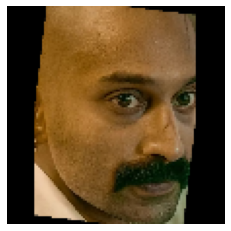

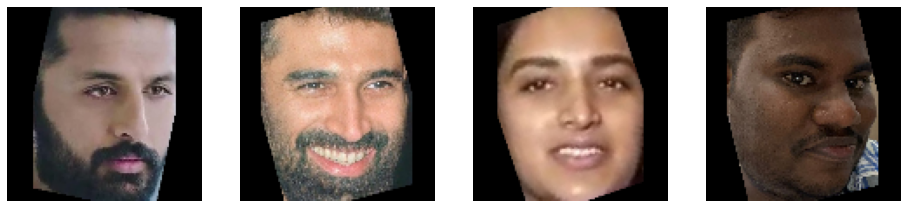

1/1 [==============================] - 0s 17ms/step
['data/CleanData/nithin/4.jpg', 0.6597310252068185]
['data/CleanData/aditya_roy_kapur/4.jpg', 0.7043054656731697]
['data/CleanData/nidhhi_agerwal/3.jpg', 0.719715894359609]
['data/CleanData/sai/2.jpeg', 0.7355175478041346]

../data/CleanData/alia_bhatt/4.jpg

INPUT PICTURE
1/1 [==============================] - 0s 19ms/step
PREDICTED AS
1/1 [==============================] - 0s 20ms/step


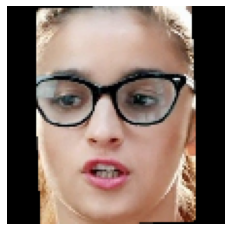

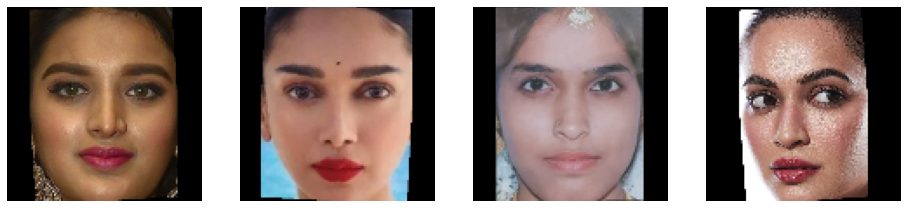

1/1 [==============================] - 0s 19ms/step
['data/CleanData/nidhhi_agerwal/4.jpg', 0.6551642759135551]
['data/CleanData/aditi_rao_hydari/2.png', 0.6765143316126354]
['data/CleanData/shaheena/1.jpeg', 0.6791635315139474]
['data/CleanData/kriti_kharbanda/3.jpg', 0.6889927568810402]

../data/CleanData/asin_thottumkal/0.png

INPUT PICTURE
1/1 [==============================] - 0s 20ms/step
PREDICTED AS
1/1 [==============================] - 0s 19ms/step


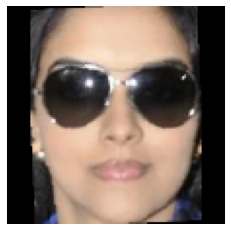

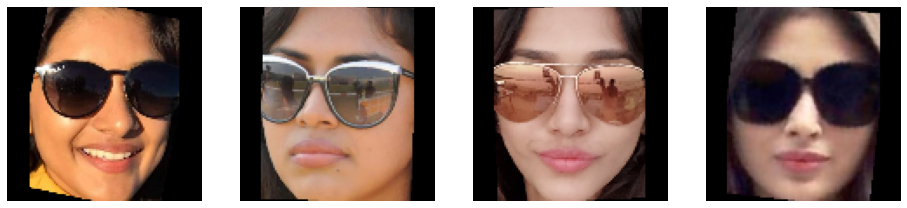

1/1 [==============================] - 0s 19ms/step
['data/CleanData/nivetha_thomas/2.jpg', 0.49368245152972096]
['data/CleanData/amala_paul/2.jpg', 0.49690808410558335]
['data/CleanData/nabha_natesh/2.jpg', 0.5619887523200883]
['data/CleanData/mouni_roy/2.jpeg', 0.5633261809000041]

../data/CleanData/kiara_advani/1.jpg

INPUT PICTURE
1/1 [==============================] - 0s 19ms/step
PREDICTED AS
1/1 [==============================] - 0s 18ms/step


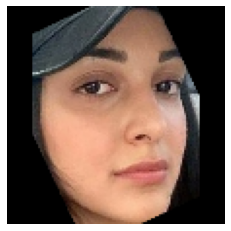

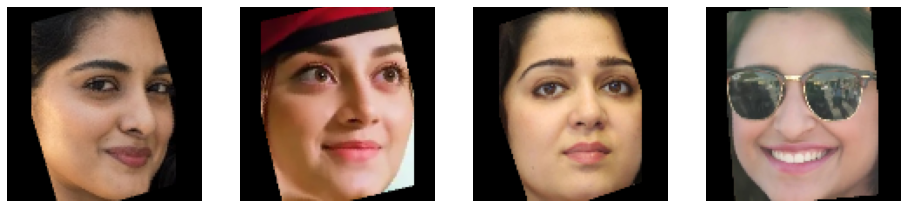

1/1 [==============================] - 0s 21ms/step
['data/CleanData/nivetha_thomas/3.jpeg', 0.5351058765779734]
['data/CleanData/alizeh_shah/0.png', 0.5626749624073983]
['data/CleanData/charmy_kaur/1.jpg', 0.57625683598872]
['data/CleanData/parineeti_chopra/1.jpg', 0.5855657179543803]

../data/CleanData/mehreen_pirzada/3.png

INPUT PICTURE
1/1 [==============================] - 0s 18ms/step
PREDICTED AS
1/1 [==============================] - 0s 18ms/step


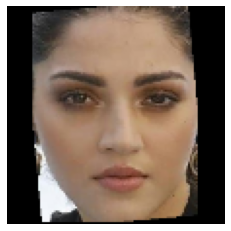

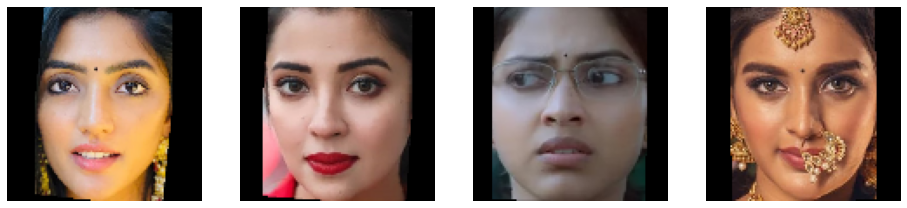

1/1 [==============================] - 0s 18ms/step
['data/CleanData/eesha_rebba/5.jpg', 0.4243464093868265]
['data/CleanData/barkha_singh/2.jpg', 0.5297383872954952]
['data/CleanData/amala_paul/3.png', 0.5495259949591258]
['data/CleanData/nidhhi_agerwal/1.jpg', 0.5663409879811374]

../data/CleanData/mehreen_pirzada/1.jpg

INPUT PICTURE
1/1 [==============================] - 0s 16ms/step
PREDICTED AS
1/1 [==============================] - 0s 19ms/step


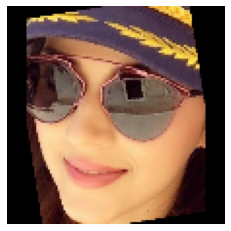

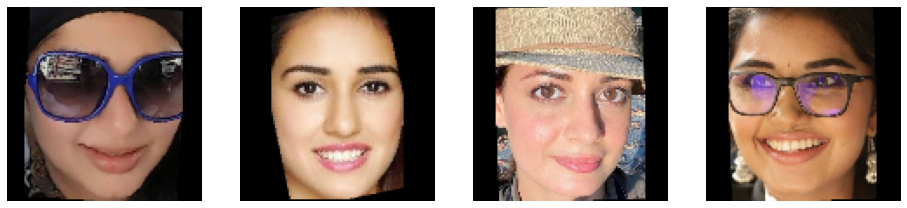

1/1 [==============================] - 0s 20ms/step
['data/CleanData/bhoomika_chawla/0.jpg', 0.5049385704668848]
['data/CleanData/disha_patani/5.jpg', 0.5382688474420356]
['data/CleanData/dia_mirza/3.jpg', 0.5395151696357288]
['data/CleanData/anupama_parameswaran/4.jpg', 0.5673167646068499]

../data/CleanData/catherine_tresa/4.jpg

INPUT PICTURE
1/1 [==============================] - 0s 30ms/step
PREDICTED AS
1/1 [==============================] - 0s 19ms/step


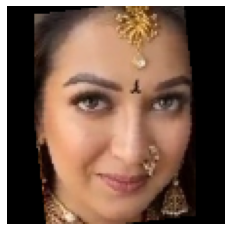

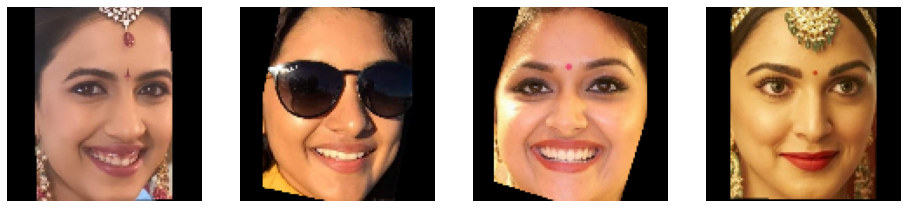

1/1 [==============================] - 0s 21ms/step
['data/CleanData/niharika_konidela/4.jpeg', 0.49957967456853314]
['data/CleanData/nivetha_thomas/2.jpg', 0.5131764610851045]
['data/CleanData/keerthi_suresh/4.jpg', 0.5140430864071595]
['data/CleanData/kiara_advani/0.jpg', 0.5257267210335673]

../data/CleanData/lavanya_tripathi/0.png

INPUT PICTURE
1/1 [==============================] - 0s 18ms/step
PREDICTED AS
1/1 [==============================] - 0s 19ms/step


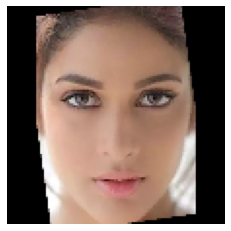

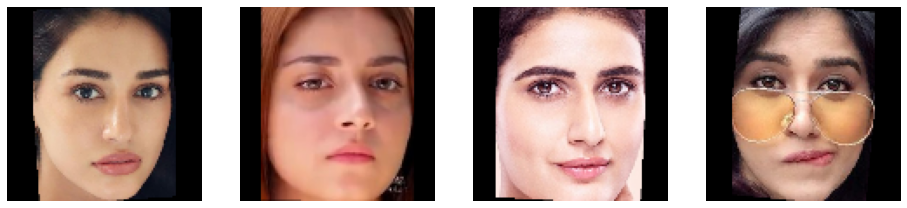

1/1 [==============================] - 0s 17ms/step
['data/CleanData/disha_patani/1.jpg', 0.5024461186003067]
['data/CleanData/alizeh_shah/5.jpg', 0.5134807529727985]
['data/CleanData/fatima_sana_shaikh/3.jpg', 0.526712224925092]
['data/CleanData/nabha_natesh/0.jpg', 0.5415112032519799]

../data/CleanData/naveen_polishetty/2.jpg

INPUT PICTURE
1/1 [==============================] - 0s 17ms/step
PREDICTED AS
1/1 [==============================] - 0s 20ms/step


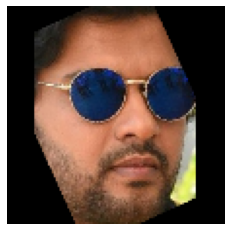

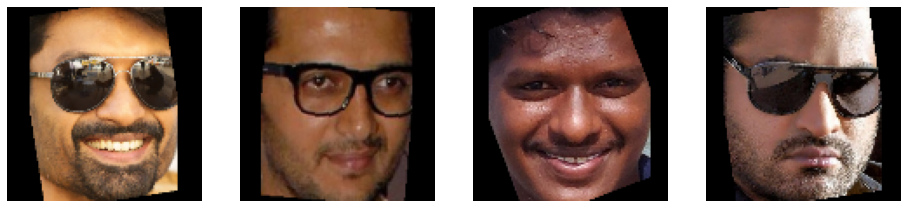

1/1 [==============================] - 0s 18ms/step
['data/CleanData/kalyan_ram/0.png', 0.4587061215692201]
['data/CleanData/riteish_deshmukh/4.jpg', 0.5225965991015106]
['data/CleanData/rajesh/1.jpg', 0.5479269307464397]
['data/CleanData/n_t_rama_rao_jr/2.jpg', 0.5752216312756216]



In [83]:
for item in FN_responses:
    img_path = "../" + item[0]
    print(img_path)
    print()
    print("INPUT PICTURE")
    plt.imshow(face_extraction_and_alignment(img_path)) 
    plt.axis("off")
    print("PREDICTED AS")
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 16))
    for idx, thing in enumerate(item[1]):
        ax[idx].imshow(face_extraction_and_alignment("../" + thing[0]))
        ax[idx].axis("off")
    plt.show()
    result = predict(img_path) 
    for item in result:
        print(item)
    print()